<a href="https://colab.research.google.com/github/nagarajgn01/anomaly-detection-autoencoder-h2o/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install & Import necessary packages

In [75]:
install.packages('caret')
install.packages('e1071')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




In [108]:
install.packages('ROCR')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘caTools’, ‘gplots’




In [45]:
install.packages("h2o", repos=(c("http://s3.amazonaws.com/h2o-release/h2o/master/1497/R", getOption("repos"))))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’




In [3]:
library(tidyverse)
library(caret) 

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




### Load Credit Card Fraudulent Data

In [4]:
creditcard <- read.csv("creditcard1.csv")

### Exploratory Data Analysis

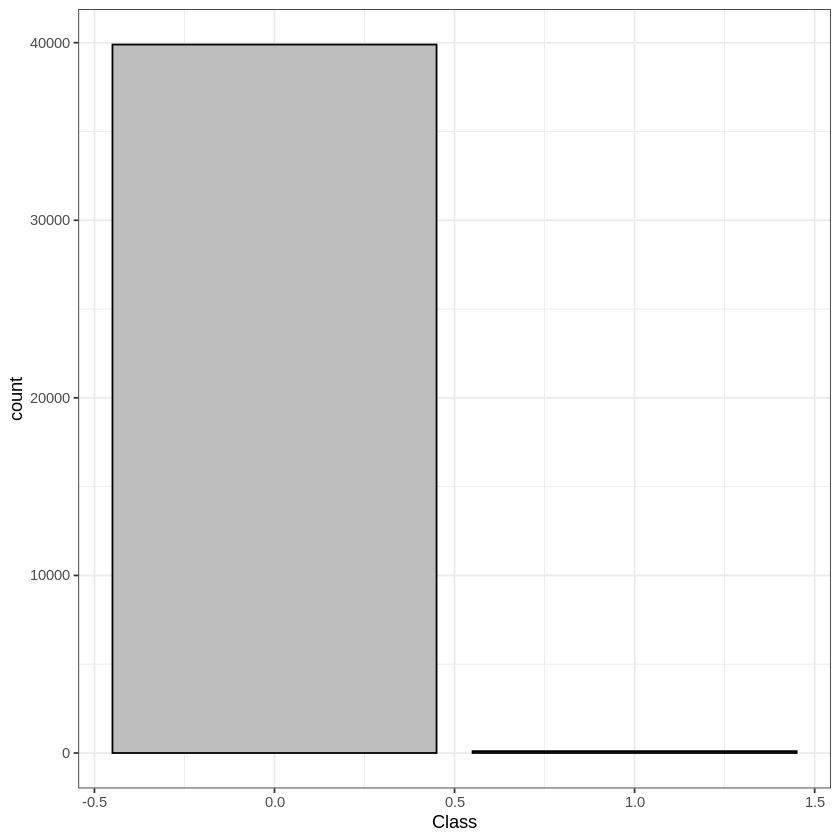

In [11]:
# Distribution on Target Class
creditcard %>% ggplot(aes(x = Class)) + geom_bar(color = "black", fill = "grey") + theme_bw()

In [12]:
summary(creditcard$Time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   15012   30717   25610   35731   40052 

In [13]:
# separate transactions by day 
creditcard$day <- ifelse(creditcard$Time > 3600 * 24, "day2", "day1") 

In [14]:
# make transaction relative to day 
creditcard$Time_day <- ifelse(creditcard$day == "day2", creditcard$Time - 86400, creditcard$Time) 

In [15]:
summary(creditcard[creditcard$day == "day1", ]$Time_day)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   15012   30717   25610   35731   40052 

In [19]:
summary(creditcard[creditcard$day == "day2", ]$Time_day)
# Transaction recorded in this data dump is limited to atmost 24 hours. Not transaction is recorded for day2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
                                                

In [22]:
# bin transactions according to time of day
creditcard$Time <- as.factor(ifelse(creditcard$Time_day <= 15012, "gr1", # mean 1st Qu.
                                    ifelse(creditcard$Time_day <= 25610, "gr2", # mean mean
                                           ifelse(creditcard$Time_day <= 35731, "gr3", # mean 3rd Qu
                                                  "gr4"))))

In [25]:
creditcard <- select(creditcard, -Time_day, -day) 

In [26]:
# convert class variable to factor 
creditcard$Class <- factor(creditcard$Class)

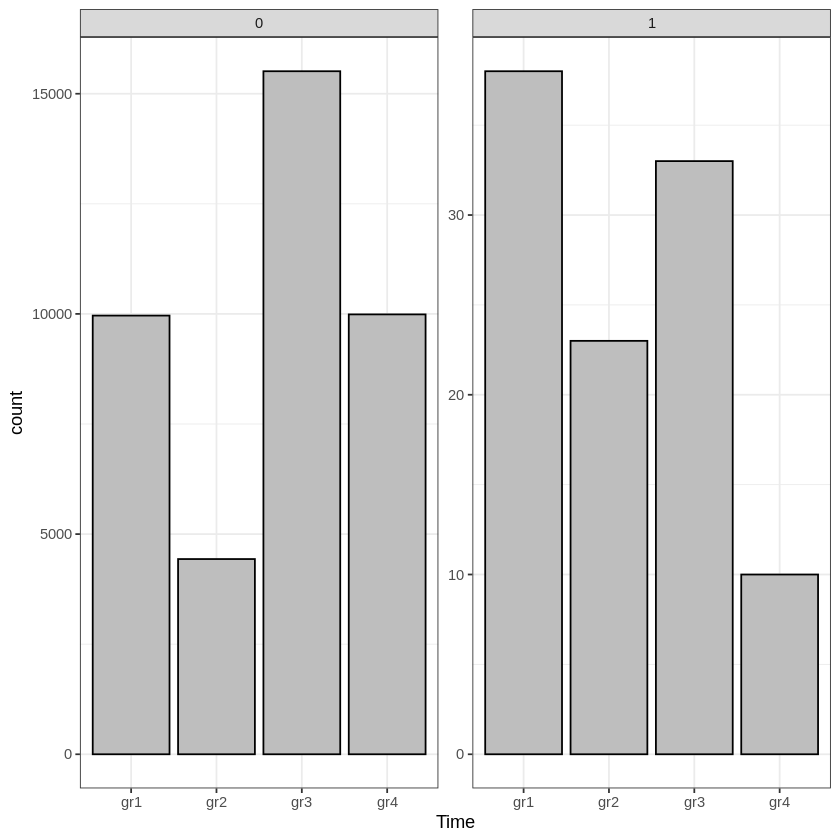

In [28]:
creditcard %>% ggplot(aes(x = Time)) + 
  geom_bar(color = "black", fill = "grey") + theme_bw() + 
  facet_wrap( ~ Class, scales = "free", ncol = 2)
  # Majority of fraud cases have happened in group 1

In [29]:
summary(creditcard[creditcard$Class == "0", ]$Amount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    7.46   23.69   87.57   79.00 7879.42 

In [131]:
# Mean amount of Fraud cases are relatively high. However Max Amount in Non Fraud is also relatively very high
summary(creditcard[creditcard$Class == "1", ]$Amount)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    1.000    3.775   97.071   99.990 1809.680 

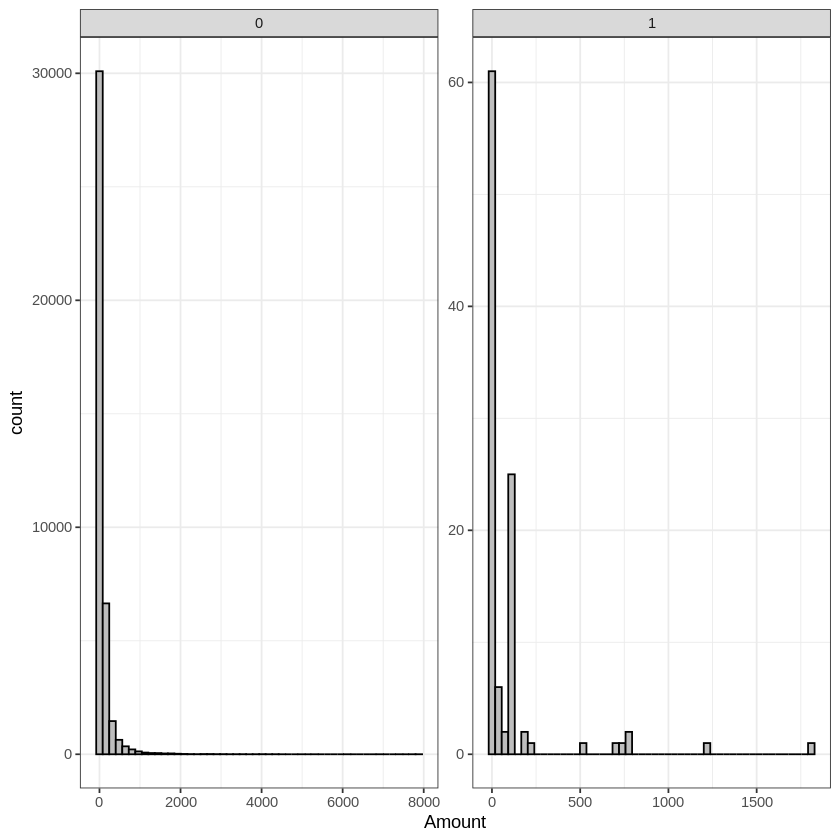

In [33]:
creditcard %>%
  ggplot(aes(x = Amount)) +
    geom_histogram(color = "black", fill = "grey", bins = 50) +
    theme_bw() +
    facet_wrap( ~ Class, scales = "free", ncol = 2)

### Modeling

In [46]:
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




In [47]:
h2o.init(nthreads = -1)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmp74eGib/file3a5f237233/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmp74eGib/file3a226eef5/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 695 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    5 months and 18 days !!! 
    H2O cluster name:           H2O_started_from_R_root_ovl938 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.18 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Ext

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (5 months and 18 days)!
Please download and install the latest version from http://h2o.ai/download/”


In [51]:
# convert data to H2OFrame 
creditcard_hf <- as.h2o(creditcard)
# Spliting data to check supervised and unsupervised learning
splits <- h2o.splitFrame(creditcard_hf, ratios = c(0.4, 0.4), seed = 42) 
train_unsupervised <- splits[[1]] 
train_supervised <- splits[[2]] 
test <- splits[[3]] 

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%


In [52]:
response <- "Class" 
features <- setdiff(colnames(train_unsupervised), response)

### Unsupervised Learning

In [53]:
# Unsupervised Learning -> Training Neural Network with AutoEncoder Model with 10-2-10 hidden layer-units, 
# 'Tanh' activation 
model_nn <- h2o.deeplearning(x = features, training_frame = train_unsupervised, 
                             model_id = "model_nn", autoencoder = TRUE, 
                             reproducible = TRUE, 
                             #slow - turn off for real problems 
                             ignore_const_cols = FALSE, seed = 42, 
                             hidden = c(10, 2, 10), 
                             epochs = 100, activation = "Tanh")

  |======================================================================| 100%


In [55]:
model_nn

Model Details:

H2OAutoEncoderModel: deeplearning
Model ID:  model_nn 
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 776 weights/biases, 16.4 KB, 1,603,800 training samples, mini-batch size 1
  layer units  type dropout       l1       l2 mean_rate rate_rms momentum
1     1    34 Input  0.00 %       NA       NA        NA       NA       NA
2     2    10  Tanh  0.00 % 0.000000 0.000000  0.325388 0.271496 0.000000
3     3     2  Tanh  0.00 % 0.000000 0.000000  0.008344 0.004532 0.000000
4     4    10  Tanh  0.00 % 0.000000 0.000000  0.098890 0.112646 0.000000
5     5    34  Tanh      NA 0.000000 0.000000  0.350704 0.406478 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.051042   0.633883 -0.068893 0.775628
3   -0.115926   0.403429  0.142009 0.000143
4    0.220332   1.075593 -0.100378 0.453583
5    0.009270   0.745439  0.195297 0.772887


H2OAutoEncoderMetrics: deeplearning
** Reported on training data. 

In [60]:
# now we need to calculate MSE or anomaly score
anmlt = h2o.anomaly(model_nn
                    , train_unsupervised
                    , per_feature = FALSE) %>% as.data.frame()

In [62]:
# create a label for healthy data
anmlt$y = 0
# view top data
head(anmlt)

,Reconstruction.MSE,y
,<dbl>,<dbl>
1,0.007559668,0
2,0.003424165,0
3,0.002125653,0
4,0.001378344,0
5,0.003121873,0
6,0.002359252,0


In [64]:
test_df <- test%>% as.data.frame()
# Number of anomaly in test data - 19
table(test_df$Class)


   0    1 
7882   19 

In [65]:
# calculate thresholds from train data
threshold = quantile(anmlt$Reconstruction.MSE, probs = 0.99)
threshold

99% 
0.011728

In [66]:
# calculate anomaly scores for test data
test_anmlt = h2o.anomaly(model_nn
                         , test
                         , per_feature = FALSE) %>% as.data.frame()

In [69]:
# create a label for healthy data
test_anmlt$y = 1
results = data.frame(rbind(anmlt,test_anmlt), threshold)

Warning message in data.frame(rbind(anmlt, test_anmlt), threshold):
“row names were found from a short variable and have been discarded”


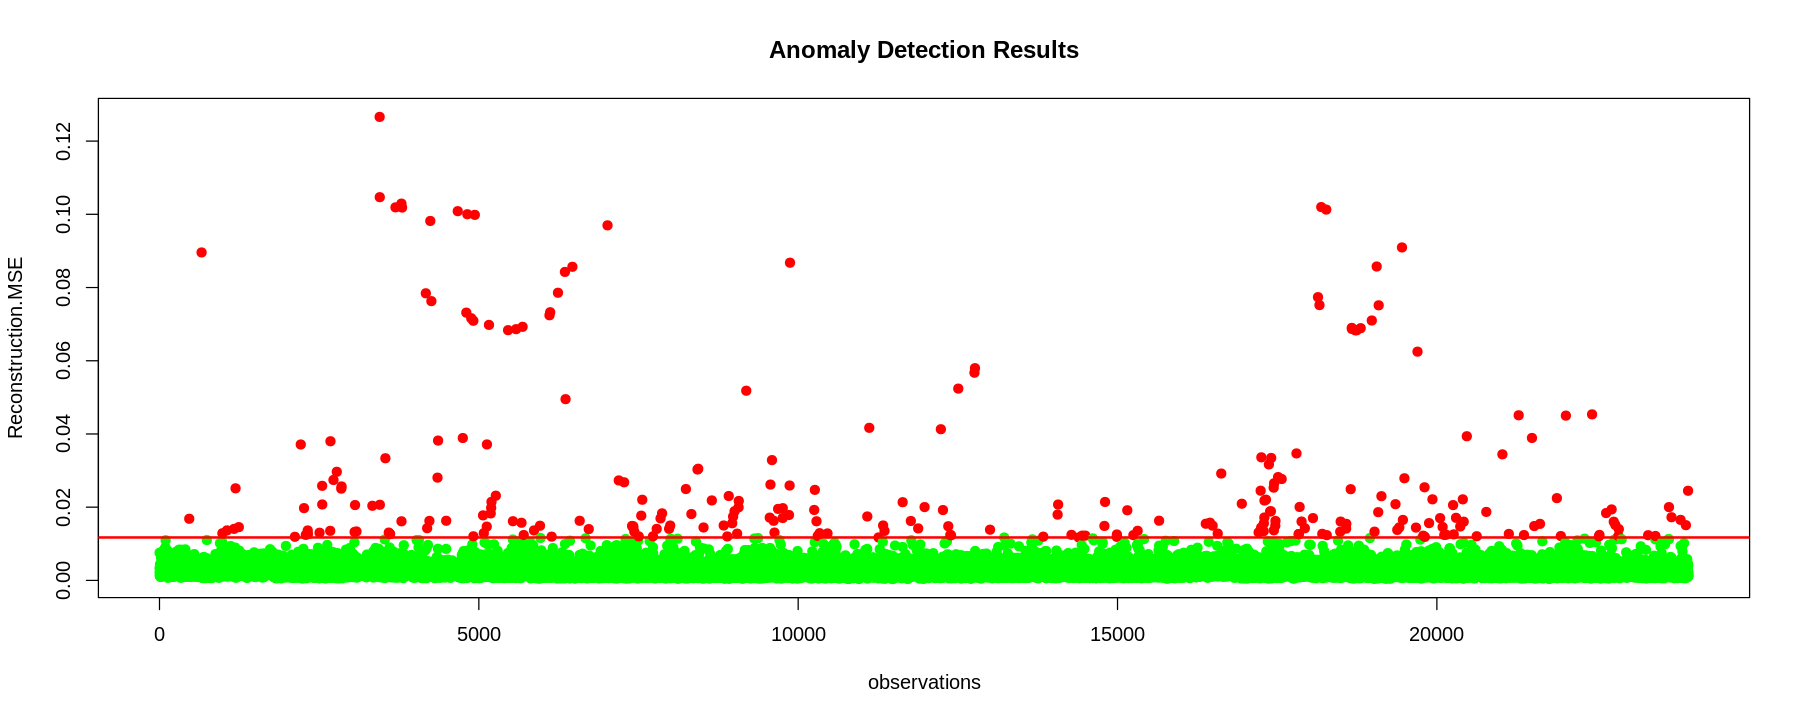

In [71]:
# Anamoly Detection Visualization based in Reconstructed MSE
options(repr.plot.width = 15, repr.plot.height = 6)
plot(results$Reconstruction.MSE, type = 'n', xlab='observations', ylab='Reconstruction.MSE', main = "Anomaly Detection Results")
points(results$Reconstruction.MSE, pch=19, col=ifelse(results$Reconstruction.MSE < threshold, "green", "red"))
abline(h=threshold, col='red', lwd=2)

In [72]:
table(results$Reconstruction.MSE > threshold)


FALSE  TRUE 
23671   268 

In [97]:
# Store data in Data frame for evaluation
dfTestNew = data.frame(test%>% as.data.frame())

In [100]:
dfTestNew$Predict = test_anmlt$Reconstruction.MSE > threshold
dfTestNew$Predict <- as.integer(as.logical(dfTestNew$Predict))
xtable = table(dfTestNew$Predict,dfTestNew$Class)
confusionMatrix(xtable)

Confusion Matrix and Statistics

   
       0    1
  0 7791    3
  1   91   16
                                          
               Accuracy : 0.9881          
                 95% CI : (0.9855, 0.9904)
    No Information Rate : 0.9976          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2509          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9885          
            Specificity : 0.8421          
         Pos Pred Value : 0.9996          
         Neg Pred Value : 0.1495          
             Prevalence : 0.9976          
         Detection Rate : 0.9861          
   Detection Prevalence : 0.9865          
      Balanced Accuracy : 0.9153          
                                          
       'Positive' Class : 0               
                                          

### Supervised Learning

In [101]:
# we take third hidden layer and try supervised learning
train_features <- h2o.deepfeatures(model_nn, train_unsupervised, layer = 3) %>%
  as.data.frame() %>%
  mutate(Class = as.factor(as.vector(train_unsupervised[, 31]))) %>%
  as.h2o()

  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%


In [81]:
features_dim <- setdiff(colnames(train_features), response)

In [84]:
# Supervised Learning -> Training Neural network for classification problem
model_nn_dim <- h2o.deeplearning(y = response,
                               x = features_dim,
                               training_frame = train_features,
                               reproducible = TRUE, #slow - turn off for real problems
                               balance_classes = TRUE,
                               ignore_const_cols = FALSE,
                               seed = 42,
                               hidden = c(10, 2, 10), 
                               epochs = 100,
                               activation = "Tanh")

  |======================================================================| 100%


In [85]:
model_nn_dim

Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1616864137016_25 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 184 weights/biases, 7.6 KB, 352,077 training samples, mini-batch size 1
  layer units    type dropout       l1       l2 mean_rate rate_rms momentum
1     1    10   Input  0.00 %       NA       NA        NA       NA       NA
2     2    10    Tanh  0.00 % 0.000000 0.000000  0.003445 0.003633 0.000000
3     3     2    Tanh  0.00 % 0.000000 0.000000  0.002475 0.003233 0.000000
4     4    10    Tanh  0.00 % 0.000000 0.000000  0.114277 0.147590 0.000000
5     5     2 Softmax      NA 0.000000 0.000000  0.037606 0.048411 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.100174   0.861062  0.103862 0.585938
3   -0.188222   0.842381  0.075080 0.118430
4    0.041641   0.495822  0.042209 0.121388
5    0.563955   1.184857  0.000000 0.143312



In [86]:
# To measure test data, we have to convert test data to reduced dimension same as training data
test_dim <- h2o.deepfeatures(model_nn, test, layer = 3)

  |======================================================================| 100%


In [88]:
h2o.predict(model_nn_dim, test_dim) %>%
  as.data.frame() %>%
  mutate(actual = as.vector(test[, 31])) %>%
  group_by(actual, predict) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))
# Model looks good in identifying fraudulent cases but many non-fraudulent cases are classified as fraud

  |======================================================================| 100%


`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.



actual,predict,n,freq
<chr>,<fct>,<int>,<dbl>
0,0,3198,0.4057346
0,1,4684,0.5942654
1,0,2,0.1052632
1,1,17,0.8947368


In [89]:
anomaly <- h2o.anomaly(model_nn, test) %>%
  as.data.frame() %>%
  tibble::rownames_to_column() %>%
  mutate(Class = as.vector(test[, 31]))

In [90]:
mean_mse <- anomaly %>%
  group_by(Class) %>%
  summarise(mean = mean(Reconstruction.MSE))

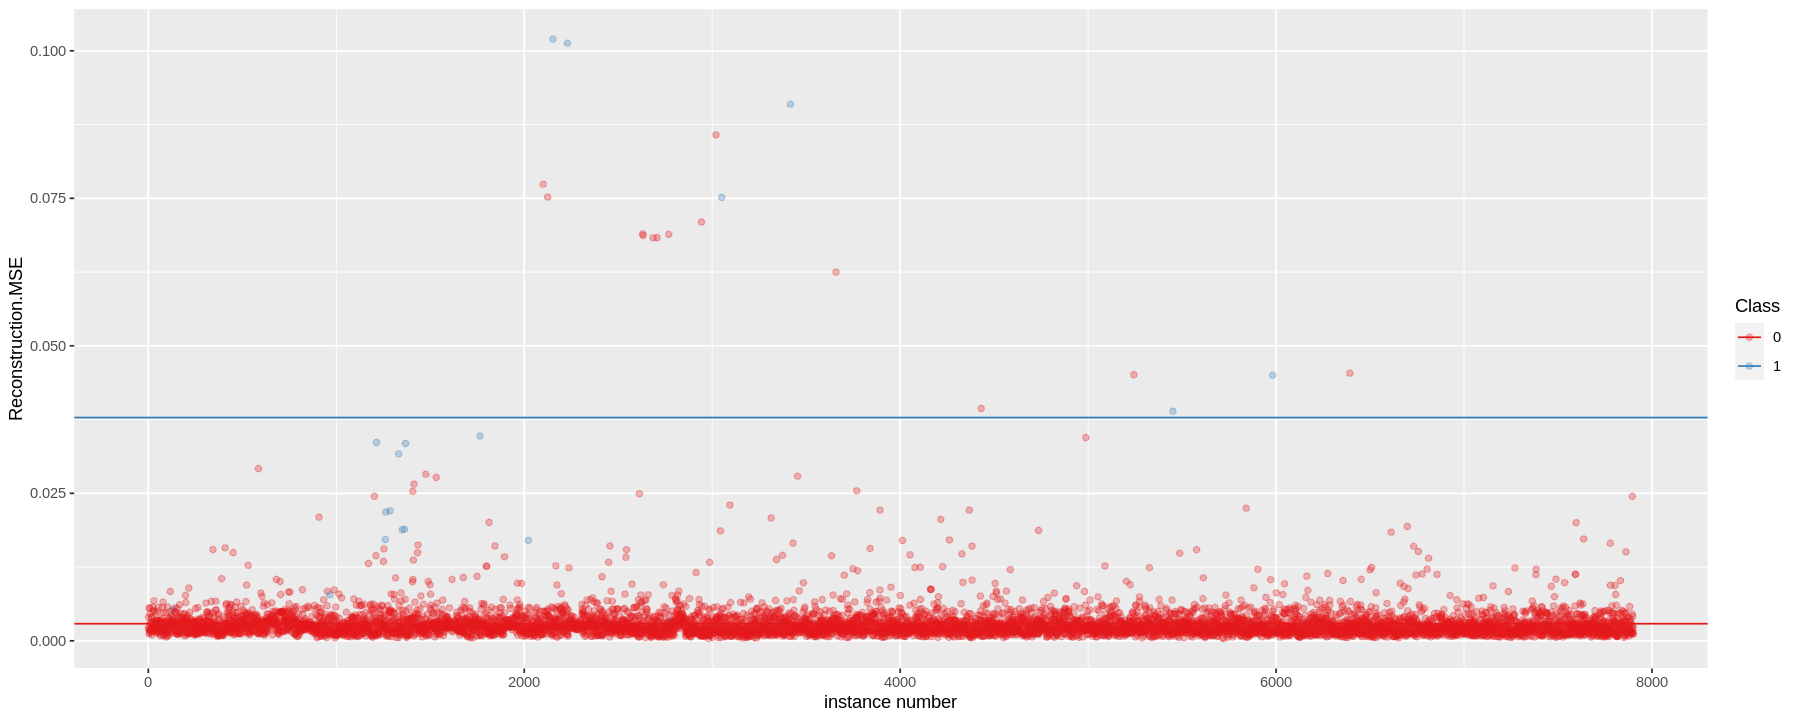

In [92]:
# How the classification looks based on Reconstructed MSE and decision boundary
ggplot(anomaly, aes(x = as.numeric(rowname), y = Reconstruction.MSE, color = as.factor(Class))) +
  geom_point(alpha = 0.3) +
  geom_hline(data = mean_mse, aes(yintercept = mean, color = Class)) +
  scale_color_brewer(palette = "Set1") +
  labs(x = "instance number",
       color = "Class")

In [94]:
# try to adjust threshold for Reconstruction MSE for better results
anomaly <- anomaly %>%
  mutate(outlier = ifelse(Reconstruction.MSE > 0.02, "outlier", "no_outlier"))

anomaly %>%
  group_by(Class, outlier) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'Class'. You can override using the `.groups` argument.



Class,outlier,n,freq
<chr>,<chr>,<int>,<dbl>
0,no_outlier,7849,0.995813245
0,outlier,33,0.004186755
1,no_outlier,7,0.368421053
1,outlier,12,0.631578947


In [102]:
# Use Pre trained model (stream lined date) for further learning
model_nn_2 <- h2o.deeplearning(y = response,
                               x = features,
                               training_frame = train_supervised,
                               pretrained_autoencoder  = "model_nn",
                               reproducible = TRUE, #slow - turn off for real problems
                               balance_classes = TRUE,
                               ignore_const_cols = FALSE,
                               seed = 42,
                               hidden = c(10, 2, 10), 
                               epochs = 100,
                               activation = "Tanh")

  |======================================================================| 100%


In [103]:
model_nn_2

Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1616864137016_37 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 424 weights/biases, 12.1 KB, 1,056,561 training samples, mini-batch size 1
  layer units    type dropout       l1       l2 mean_rate rate_rms momentum
1     1    34   Input  0.00 %       NA       NA        NA       NA       NA
2     2    10    Tanh  0.00 % 0.000000 0.000000  0.813176 0.377658 0.000000
3     3     2    Tanh  0.00 % 0.000000 0.000000  0.004187 0.002128 0.000000
4     4    10    Tanh  0.00 % 0.000000 0.000000  0.035646 0.102071 0.000000
5     5     2 Softmax      NA 0.000000 0.000000  0.005266 0.002125 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.032025   0.587983  0.085849 1.117132
3   -0.090482   0.434420  0.524944 0.232917
4    0.604671   1.020529  0.318562 0.951015
5    0.563535   1.849452  0.000000 1.41892

In [104]:
# Predict on test data
pred <- as.data.frame(h2o.predict(object = model_nn_2, newdata = test)) %>%
  mutate(actual = as.vector(test[, 31]))

  |======================================================================| 100%


In [105]:
pred %>%
  group_by(actual, predict) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n)) 
# Even though we have missed 4 fraud, we have brought down misclssification of non-fraud cases from 33 to 10

`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.



actual,predict,n,freq
<chr>,<fct>,<int>,<dbl>
0,0,7872,0.998731286
0,1,10,0.001268714
1,0,4,0.210526316
1,1,15,0.789473684


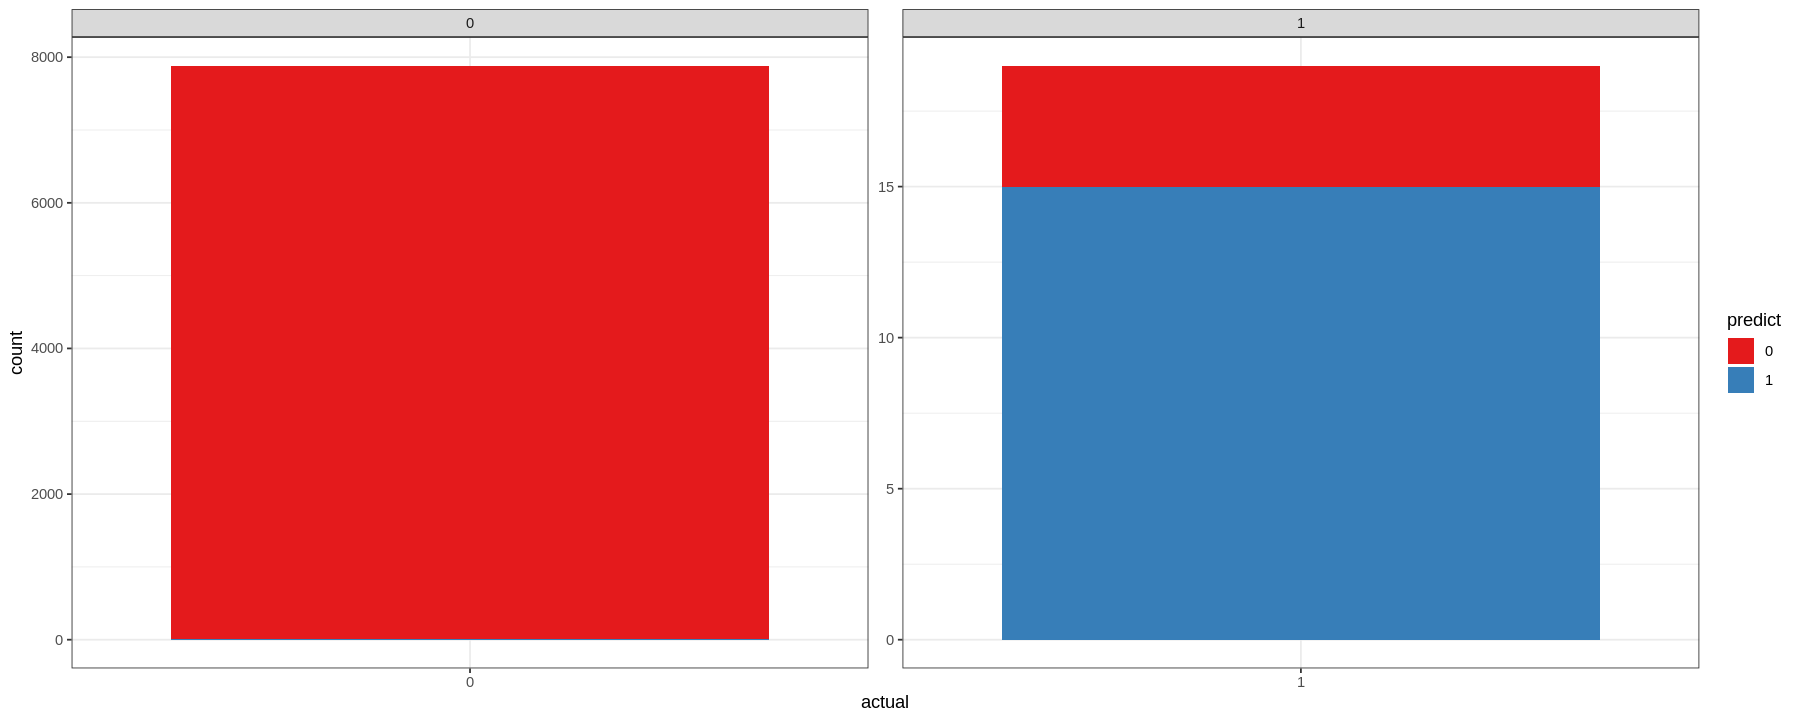

In [106]:
pred %>%
  ggplot(aes(x = actual, fill = predict)) +
    geom_bar() +
    theme_bw() +
    scale_fill_brewer(palette = "Set1") +
    facet_wrap( ~ actual, scales = "free", ncol = 2)

In [116]:
# Try different threshold to improve accuracy
thresholds <- seq(from = 0, to = 1, by = 0.1)
pred_thresholds <- data.frame(actual = pred$actual)

for (threshold in thresholds) {
  
  prediction <- ifelse(pred$p1 > threshold, 1, 0)
  prediction_true <- ifelse(pred_thresholds$actual == prediction, TRUE, FALSE)
  pred_thresholds <- cbind(pred_thresholds, prediction_true)

}

colnames(pred_thresholds)[-1] <- thresholds

`summarise()` has grouped output by 'actual', 'x'. You can override using the `.groups` argument.



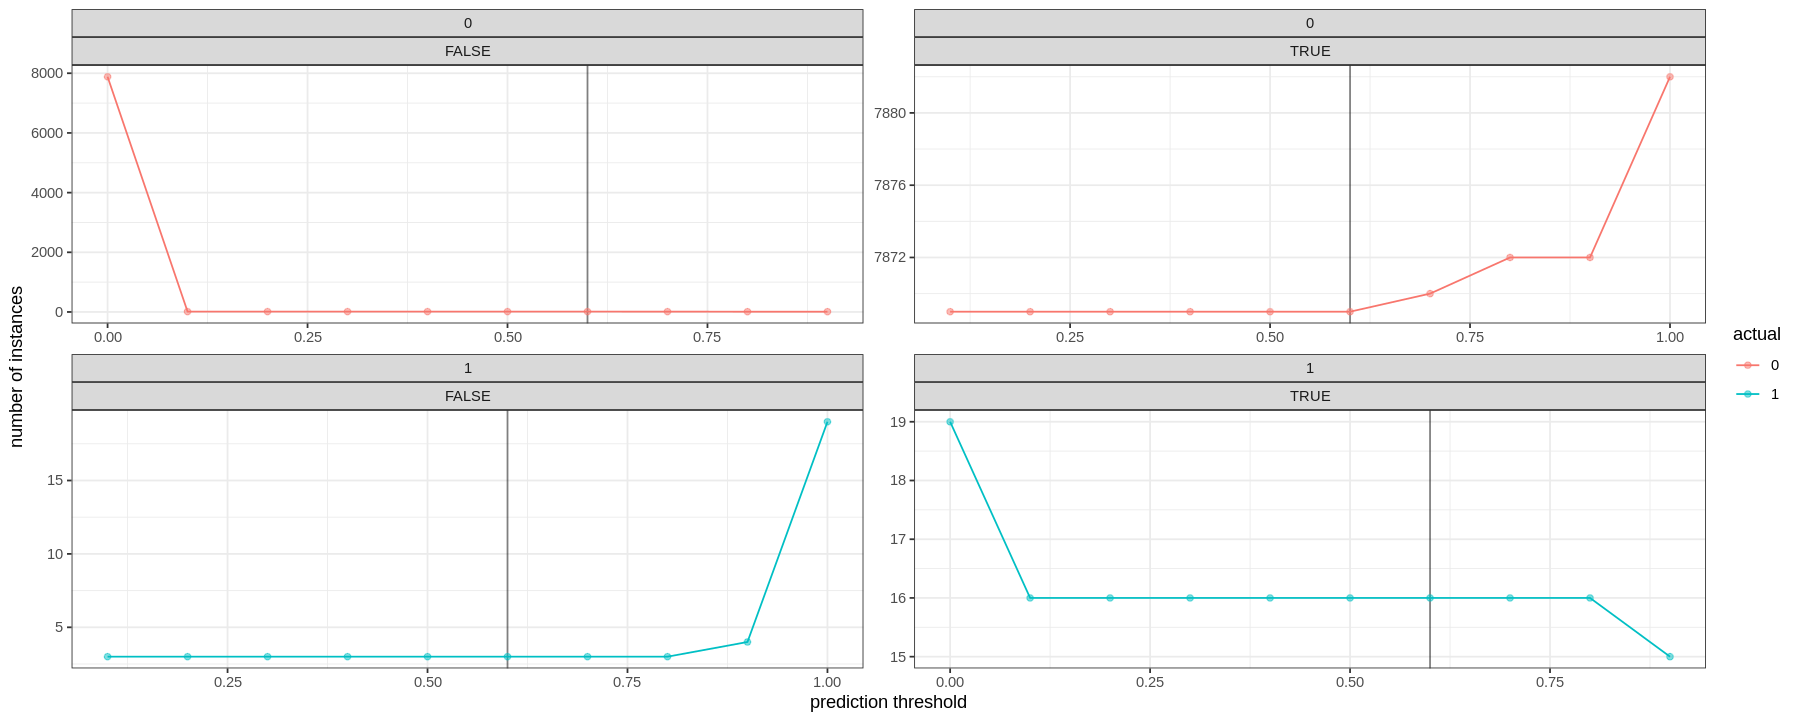

In [117]:
pred_thresholds %>%
  gather(x, y, 2:ncol(pred_thresholds)) %>%
  group_by(actual, x, y) %>%
  summarise(n = n()) %>%
  ggplot(aes(x = as.numeric(x), y = n, color = actual)) +
    geom_vline(xintercept = 0.6, alpha = 0.5) +
    geom_line() +
    geom_point(alpha = 0.5) +
    theme_bw() +
    facet_wrap(actual ~ y, scales = "free", ncol = 2) +
    labs(x = "prediction threshold",
         y = "number of instances")

In [130]:
# From graph we can observe that is we can increase threshold from 0.5 to 0.8 without loosing correct fraud cases
pred %>%
  mutate(predict = ifelse(pred$p1 > 0.8, 1, 0)) %>%
  group_by(actual, predict) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.



actual,predict,n,freq
<chr>,<dbl>,<int>,<dbl>
0,0,7872,0.998731286
0,1,10,0.001268714
1,0,3,0.157894737
1,1,16,0.842105263
